In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [2]:
from datasets import load_dataset

ds = load_dataset("rubrix/research_papers_multi-label", split='train', streaming=True)
ds_head = ds.take(1000)
papers=list(ds_head)

In [18]:
import pandas as pd

df_ground_truth_data = pd.read_csv('project/ground-truth-data.csv')

In [19]:
ground_truth = df_ground_truth_data.sample(n=1000).to_dict(orient='records')

In [5]:
ground_truth

[{'query': 'What is the typical timespan of an FU Orionis outburst, and how does this timescale relate to the typical timescales of particle transport in a protoplanetary disk?',
  'pid': '7bfe5b52'},
 {'query': 'What is the maximum performance improvement observed when using these architectures compared to baseline models?',
  'pid': '8679cd2d'},
 {'query': 'Describe a  algorithm designed to address the challenge of retrieving the backbone in weighted MAX-SAT.',
  'pid': '08862526'},
 {'query': 'What is the key advantage of adaptively partitioning the hyperparameter search space?',
  'pid': '55e1b93f'},
 {'query': 'This paper proposes an alternative to the parametric bootstrap. What are the conditions for achieving accurate inference in finite samples with this method?',
  'pid': '4f4e688c'},
 {'query': 'What are the challenges of using machine learning for anomaly detection in multi-view cloud environments?',
  'pid': '91b2eca7'},
 {'query': 'What is the name of the proposed architec

In [5]:
from tqdm.auto import tqdm

In [6]:
from openai import OpenAI
from elasticsearch import Elasticsearch

client = OpenAI(
    base_url='https://api.groq.com/openai/v1',
    api_key='<INSERT API KEY>'
)

es_client = Elasticsearch('http://localhost:9200')

In [7]:
import hashlib
for paper in tqdm(papers):
    paper['pid'] = hashlib.md5((paper['inputs']['abstract'] + paper['inputs']['title']).encode('utf-8')).hexdigest()[:8]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [110]:
def prompt_builder_eval(paper):
    prompt_template = """
    You are an evaluator of the responses that are provided to you. 
    You will be given two responses two evalute if they are relevant. 

    Response 1: 
    {orig_ans}

    Response 2: 
    {llm_ans}

    Based on the contexts of the response, respond with ONLY one of the following:
    RELEVANT | PARTLY RELEVANT | NOT RELEVANT 

    DO NOT provide any other information other than the relevance of the response.
    """.strip()
    
    context = """

    Title: {title}

    Abstract: {abs}
    
    """
    
    prompt = prompt_template.format(orig_ans = paper['orig_ans'], llm_ans=paper['llm_ans'])

    return prompt


In [9]:
def prompt_builder(query, results):
    prompt_template =  """
    You are a librarian trying to help a researcher look for the research papers they are looking for.
    Make sure you only use the facts from the context to answer the question and nothing outside.
    
    Context: {context}

    Questions: {query}

    If you find something that works, respond in this format:

    Title: <insert the title here>

    Abstract: <insert full Abstract here>
    """
    context = ''
    for doc in results:
        context += f"\nTitle: {doc['_source']['inputs']['title']}\nAbstract: {doc['_source']['inputs']['abstract']}"

    prompt = prompt_template.format(query=query, context = context)

    return prompt

def llm(prompt, model):
    response = client.chat.completions.create(
        model = model,
        messages = [{'role': 'user', 'content': prompt}]
    )

    return response.choices[0].message.content

def rag(query, model):
    result_docs = elastic_search(query)
    prompt = prompt_builder(query, result_docs)
    return llm(prompt, model)

def elastic_search(query, index='academic_papers'):
    v_q = model.encode(query)
    
    search_query = {
        "field": "v_at",
        "query_vector": v_q,
        "k": 5,
        "num_candidates":10000
    }

    es_results = es_client.search(
        index=index,
        knn=search_query, 
        source=['inputs', 'pid', 'v_at']
    )

    return es_results['hits']['hits']

In [62]:
def doc_idx(pid):
    for paper in papers:
        if paper['pid'] == pid:
            return paper['inputs'] 
    return 0

In [63]:
doc_idx('e2508c43')

{'abstract': '  We introduce and develop the notion of spherical polyharmonics, which are a\nnatural generalisation of spherical harmonics. In particular we study the\ntheory of zonal polyharmonics, which allows us, analogously to zonal harmonics,\nto construct Poisson kernels for polyharmonic functions on the union of rotated\nballs. We find the representation of Poisson kernels and zonal polyharmonics in\nterms of the Gegenbauer polynomials. We show the connection between the\nclassical Poisson kernel for harmonic functions on the ball, Poisson kernels\nfor polyharmonic functions on the union of rotated balls, and the Cauchy-Hua\nkernel for holomorphic functions on the Lie ball.\n',
 'title': 'Spherical polyharmonics and Poisson kernels for polyharmonic functions'}

In [101]:
for element in tqdm(ground_truth):
    context = """

        Title: {title}

        Abstract: {abs}
        
    """.strip()
    input=doc_idx(element['pid'])
    context_fill = context.format(
            title=input['title'], 
            abs=input['abstract']
        )
    element['orig_ans'] = context_fill

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
for element in tqdm(ground_truth[846:]):
    element['llm_ans'] = rag(element['query'], 'llama3-70b-8192')

  0%|          | 0/154 [00:00<?, ?it/s]

In [32]:
df_sample = pd.DataFrame(ground_truth, columns=['query', 'pid', 'orig_ans', 'llm_ans'])

In [34]:
df_sample.to_csv('llama70b-results.csv', index=False)

In [54]:
ground_truth

[{'query': 'How do the models learned by PULSE facilitate musical interpretation?',
  'pid': '6c996f7a',
  'orig_ans': [{'abstract': '  Predictive models for music are studied by researchers of algorithmic\ncomposition, the cognitive sciences and machine learning. They serve as base\nmodels for composition, can simulate human prediction and provide a\nmultidisciplinary application domain for learning algorithms. A particularly\nwell established and constantly advanced subtask is the prediction of\nmonophonic melodies. As melodies typically involve non-Markovian dependencies\ntheir prediction requires a capable learning algorithm. In this thesis, I apply\nthe recent feature discovery and learning method PULSE to the realm of symbolic\nmusic modeling. PULSE is comprised of a feature generating operation and\nL1-regularized optimization. These are used to iteratively expand and cull the\nfeature set, effectively exploring feature spaces that are too large for common\nfeature selection app

In [68]:
from sklearn.metrics.pairwise import cosine_similarity

for element in tqdm(ground_truth):
    v_llm = model.encode(element['llm_ans'])
    v_orig = model.encode(element['orig_ans'])
    element['cos_sim'] = v_llm.dot(v_orig)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
df_sample = pd.DataFrame(ground_truth, columns=['query', 'pid', 'orig_ans', 'llm_ans', 'cos_sim'])

In [75]:
df_sample

,query,pid,orig_ans,llm_ans,cos_sim
0,How do the models learned by PULSE facilitate ...,6c996f7a,Title: Learning a Predictive Model for Music U...,Title: Learning a Predictive Model for Music U...,0.982891
1,What is the primary discrepancy between measur...,ed3bbe2a,Title: Clarifying the Hubble constant tension ...,The primary discrepancy between measurements o...,0.944994
2,How is the Euclidean stochastic variance reduc...,b06c0299,Title: Riemannian stochastic variance reduced ...,Title: Riemannian stochastic variance reduced ...,1.000000
3,How was the dynamical matrix of the network mo...,a747a15d,Title: Finite-time scaling at the Anderson tra...,"I apologize, but after reviewing the provided ...",0.321097
4,What are the advantages of using FLMC over LMC...,057c4857,Title: Non-Asymptotic Analysis of Fractional L...,"Unfortunately, based on the provided abstracts...",0.881944
...,...,...,...,...,...
995,How do non-equal wave vectors in beam splitter...,f790353b,Title: Asymmetric Mach-Zehnder atom interferom...,I think I can help you with that!\n\nTitle: As...,0.956804
996,What type of neural networks are used to learn...,70416061,Title: Deep Learning Scooping Motion using Bil...,Here is the answer to your question:\n\nTitle:...,0.987072
997,What is Ensemble Sampling and how does it rela...,49981aba,Title: Ensemble Sampling\n\n Abstract: ...,I think I can help you with that!\n\nTitle: En...,0.971426
998,How can computational techniques based on an e...,30533fe4,Title: Stigmergy-based modeling to discover ur...,Title: Stigmergy-based modeling to discover ur...,1.000000


In [74]:
df_sample['cos_sim'].describe()

count    1000.000000
mean        0.950976
std         0.124030
min         0.090727
25%         0.963539
50%         0.987853
75%         1.000000
max         1.000000
Name: cos_sim, dtype: float64

/var/folders/s9/7x6wjtq126773lhfsl5rqqv40000gn/T/ipykernel_30879/477144320.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sample['cos_sim'])


<Axes: xlabel='cos_sim', ylabel='Density'>

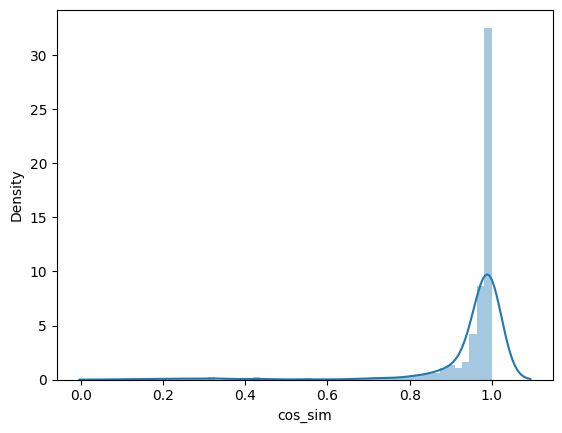

In [97]:
import seaborn as sns

sns.distplot(df_sample['cos_sim'])

In [76]:
sample2 = df_ground_truth_data.sample(n=1000).to_dict(orient='records')

In [78]:
for element in tqdm(sample2):
    context = """

        Title: {title}

        Abstract: {abs}
        
    """.strip()
    input=doc_idx(element['pid'])
    context_fill = context.format(
            title=input['title'], 
            abs=input['abstract']
        )
    element['orig_ans'] = context_fill

  0%|          | 0/1000 [00:00<?, ?it/s]

In [87]:
for element in tqdm(sample2):
    element['llm_ans'] = rag(element['query'], 'llama3-8b-8192')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [91]:
from sklearn.metrics.pairwise import cosine_similarity

for element in tqdm(sample2):
    v_llm = model.encode(element['llm_ans'])
    v_orig = model.encode(element['orig_ans'])
    element['cos_sim'] = v_llm.dot(v_orig)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [92]:
df_sample_8b = pd.DataFrame(sample2, columns=['query', 'pid', 'orig_ans', 'llm_ans', 'cos_sim'])

In [93]:
df_sample_8b.to_csv('llama8b-results.csv', index=False)

/var/folders/s9/7x6wjtq126773lhfsl5rqqv40000gn/T/ipykernel_30879/1445151781.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sample_8b['cos_sim'])


<Axes: xlabel='cos_sim', ylabel='Density'>

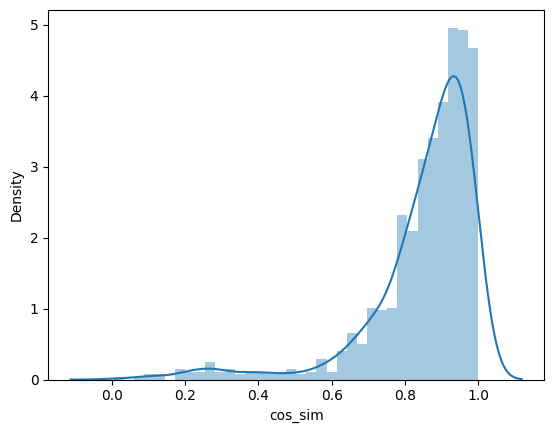

In [94]:
sns.distplot(df_sample_8b['cos_sim'])

In [95]:
import matplotlib.pyplot as plt

/var/folders/s9/7x6wjtq126773lhfsl5rqqv40000gn/T/ipykernel_30879/1329346553.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sample['cos_sim'], label='llama70b')
/var/folders/s9/7x6wjtq126773lhfsl5rqqv40000gn/T/ipykernel_30879/1329346553.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(

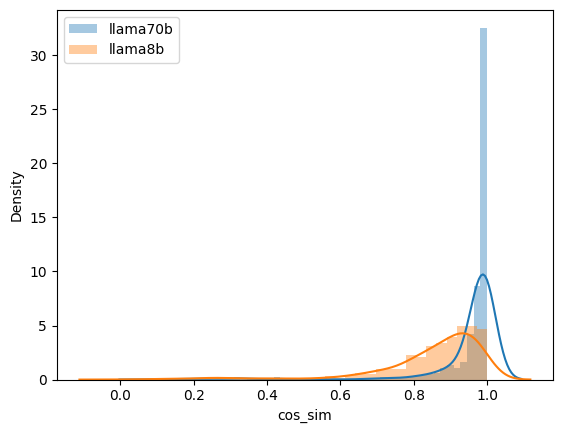

In [96]:
sns.distplot(df_sample['cos_sim'], label='llama70b')
sns.distplot(df_sample_8b['cos_sim'], label='llama8b')
plt.legend()

In [111]:
for element in tqdm(ground_truth):
    element['relevance'] = llm(prompt_builder_eval(element), 'gemma2-9b-it')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [131]:
df_sample = pd.DataFrame(ground_truth, columns=['query', 'pid', 'orig_ans', 'llm_ans', 'cos_sim', 'relevance'])

In [130]:
ground_truth[760]['relevance'] = 'RELEVANT \n'

In [133]:
df_sample

,query,pid,orig_ans,llm_ans,cos_sim,relevance
0,How do the models learned by PULSE facilitate ...,6c996f7a,Title: Learning a Predictive Model for Music U...,I think I found what you're looking for!\n\nTi...,0.982891,RELEVANT \n
1,What is the primary discrepancy between measur...,ed3bbe2a,Title: Clarifying the Hubble constant tension ...,"Based on the given context, I found the answer...",0.944994,RELEVANT \n
2,How is the Euclidean stochastic variance reduc...,b06c0299,Title: Riemannian stochastic variance reduced ...,Title: Riemannian stochastic variance reduced ...,1.000000,RELEVANT \n
3,How was the dynamical matrix of the network mo...,a747a15d,Title: Finite-time scaling at the Anderson tra...,I'm happy to help you with that!\n\nAfter revi...,0.321097,NOT RELEVANT \n
4,What are the advantages of using FLMC over LMC...,057c4857,Title: Non-Asymptotic Analysis of Fractional L...,Title: Non-Asymptotic Analysis of Fractional L...,0.881944,RELEVANT \n
...,...,...,...,...,...,...
995,How do non-equal wave vectors in beam splitter...,f790353b,Title: Asymmetric Mach-Zehnder atom interferom...,I think I can help you with that!\n\nTitle: As...,0.956804,RELEVANT \n
996,What type of neural networks are used to learn...,70416061,Title: Deep Learning Scooping Motion using Bil...,Here is the answer to your question:\n\nTitle:...,0.987072,NOT RELEVANT \n
997,What is Ensemble Sampling and how does it rela...,49981aba,Title: Ensemble Sampling\n\n Abstract: ...,I think I can help you with that!\n\nTitle: En...,0.971426,RELEVANT \n
998,How can computational techniques based on an e...,30533fe4,Title: Stigmergy-based modeling to discover ur...,Title: Stigmergy-based modeling to discover ur...,1.000000,RELEVANT \n


In [137]:
df_sample['relevance'].describe()

count            1000
unique             10
top       RELEVANT \n
freq              845
Name: relevance, dtype: object

In [135]:
df_sample['relevance'].count()

np.int64(1000)

In [138]:
for element in tqdm(sample2):
    element['relevance'] = llm(prompt_builder_eval(element), 'gemma2-9b-it')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [139]:
df_sample_8b = pd.DataFrame(sample2, columns=['query', 'pid', 'orig_ans', 'llm_ans', 'cos_sim', 'relevance'])

In [140]:
df_sample_8b['relevance'].describe()

count            1000
unique             15
top       RELEVANT \n
freq              769
Name: relevance, dtype: object